# Feature Extraction and engineering

This notebook will go through the process of extracting and engineering features such as a fighter's win/loss/draw counts, striking accuracy and submission success rate. These additional features should give the models more information with which to predict.

In [55]:
# Imports
import pandas as pd
import ds_tools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option('display.max_columns', None)

In [56]:
# Load cleaned data
ufc_df = pd.read_csv('data/outputs/cleaned_and_processed.csv', index_col=0)

In [57]:
ufc_df.sort_values(by='Date', inplace=True)
ufc_df.reset_index(drop=True, inplace=True)
ufc_df.head()

,Date,Winner,Method,Weight_class,W_round,W_round_time,R_KD,B_KD,R_sub_att,B_sub_att,R_rev,B_rev,R_ctrl,B_ctrl,R_link,B_link,N_Rounds,Fight_time,R_total_str_att,R_total_str_land,B_total_str_att,B_total_str_land,R_TD_att,R_TD_land,B_TD_att,B_TD_land,R_sig_str_att,R_sig_str_land,B_sig_str_att,B_sig_str_land,R_sig_str_head_att,R_sig_str_head_land,B_sig_str_head_att,B_sig_str_head_land,R_sig_str_body_att,R_sig_str_body_land,B_sig_str_body_att,B_sig_str_body_land,R_sig_str_leg_att,R_sig_str_leg_land,B_sig_str_leg_att,B_sig_str_leg_land,R_sig_str_dist_att,R_sig_str_dist_land,B_sig_str_dist_att,B_sig_str_dist_land,R_sig_str_clinch_att,R_sig_str_clinch_land,B_sig_str_clinch_att,B_sig_str_clinch_land,R_sig_str_ground_att,R_sig_str_ground_land,B_sig_str_ground_att,B_sig_str_ground_land,R_Height,R_Reach,R_Stance,B_Height,B_Reach,B_Stance,R_age,B_age
0,1993-11-12,R,Sub,Open Weight,1,104,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,http://ufcstats.com/fighter-details/429e7d3725...,http://ufcstats.com/fighter-details/279093302a...,1,104,4.0,3.0,0.0,0.0,3.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,73.0,75.0,Southpaw,77.0,79.0,Orthodox,26.0,34.0
1,1993-11-12,R,Sub,Open Weight,1,52,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,http://ufcstats.com/fighter-details/6ceff86fae...,http://ufcstats.com/fighter-details/02fc8f50f5...,1,52,9.0,3.0,7.0,1.0,2.0,1.0,0.0,0.0,9.0,3.0,7.0,1.0,7.0,3.0,5.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,9.0,3.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.0,73.0,Southpaw,74.0,76.0,Orthodox,24.0,29.0
2,1993-11-12,R,KO,Open Weight,1,260,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,http://ufcstats.com/fighter-details/598a58db87...,http://ufcstats.com/fighter-details/d3711d3784...,1,260,53.0,38.0,29.0,13.0,0.0,0.0,0.0,0.0,27.0,15.0,28.0,12.0,23.0,12.0,19.0,7.0,4.0,3.0,6.0,3.0,0.0,0.0,3.0,2.0,10.0,4.0,7.0,0.0,9.0,4.0,19.0,10.0,8.0,7.0,2.0,2.0,76.0,78.0,Orthodox,77.0,79.0,Orthodox,29.0,29.0
3,1993-11-12,R,Sub,Open Weight,1,57,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,http://ufcstats.com/fighter-details/429e7d3725...,http://ufcstats.com/fighter-details/63b65af1c5...,1,57,12.0,12.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,75.0,Southpaw,73.0,72.0,Orthodox,26.0,29.0
4,1993-11-12,R,Sub,Open Weight,1,138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,http://ufcstats.com/fighter-details/429e7d3725...,http://ufcstats.com/fighter-details/a5c53b3ddb...,1,138,7.0,4.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,75.0,Southpaw,73.0,75.0,Orthodox,26.0,30.0


In [59]:
streak_dict = {}
R_streak = []
B_streak = []
# Iterate through rows
for i, row in ufc_df.iterrows():
# Check R and B links
    for corner in ['R', 'B']:
        fighter = row[corner + '_link']
    
        # If link not in dict, add. Initial value based on outcome
        if fighter not in streak_dict:
            globals()[corner+'_streak'].append(0)
            # If win 1
            if row['Winner'] == corner:
                streak_dict[fighter] = 1
            # Draw 0
            elif row['Winner'] == 'Draw':
                streak_dict[fighter] = 0
            # Lose -1
            else:
                streak_dict[fighter] = -1
        else:
            # Add existing streak
            globals()[corner+'_streak'].append(streak_dict[fighter])

            # Update streak dict with current fight outcome
            # +=1 for win, 1 if < 1
            if row['Winner'] == corner:
                streak_dict[fighter] = streak_dict[fighter] + 1 if streak_dict[fighter] > 0 else 1
            # =0 for draw
            elif row['Winner'] == 'Draw':
                streak_dict[fighter] = 0
            # -=1 for lose, -1 if > -1
            else:
                streak_dict[fighter] = streak_dict[fighter] - 1 if streak_dict[fighter] < 0 else -1

ufc_df['R_streak'] = R_streak
ufc_df['B_streak'] = B_streak


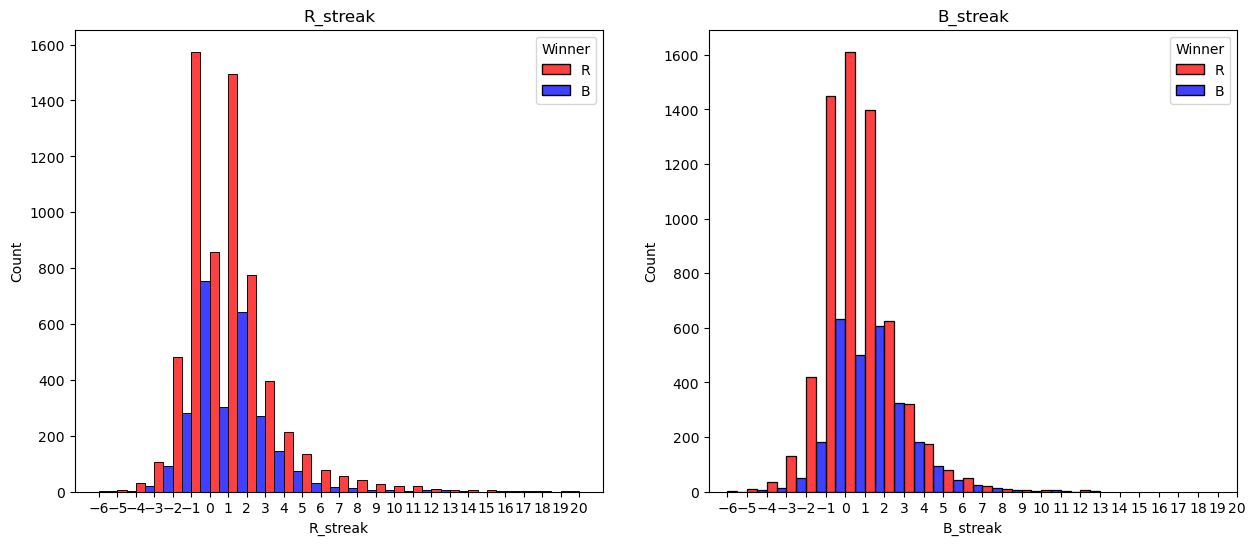

In [109]:
ufc_no_draws = ufc_df[ufc_df['Winner'].isin(['R', 'B'])]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot for R_streak
sns.histplot(data=ufc_no_draws, x='R_streak', hue='Winner', multiple='dodge', palette={'R': 'red', 'B': 'blue'}, binwidth=1, ax=axes[0])
axes[0].set_ylabel('Count')
axes[0].set_title('R_streak')
axes[0].set_xticks(np.arange(ufc_no_draws['R_streak'].min(), ufc_no_draws['R_streak'].max() + 1, 1))


# Plot for B_streak
sns.histplot(data=ufc_no_draws, x='B_streak', hue='Winner', multiple='dodge', palette={'R': 'red', 'B': 'blue'}, binwidth=1, ax=axes[1])
axes[1].set_ylabel('Count')
axes[1].set_title('B_streak')
axes[1].set_xticks(np.arange(ufc_no_draws['R_streak'].min(), ufc_no_draws['R_streak'].max() + 1, 1))


plt.show()

In [60]:
def outcomes(row):
    for corner in ['R', 'B']:

        # Get link for each fighter
        link = row[corner + '_link']

        # Get all fights previous to date
        date = row['Date']
        prev_fights = ufc_df[(ufc_df[['R_link', 'B_link']].isin([link]).any(axis=1)) & (ufc_df['Date'] < date)]

        # Get number of draws
        draws = (prev_fights['Winner'] == 'Draw').sum()
        row[corner + '_D'] = draws

        # Get number of winners

        # Get winning corners, add '_link to refer to correct column
        winners = prev_fights[prev_fights['Winner'] != 'Draw'][['Winner']]+'_link'
        # Reset index to access indices in ufc_df
        winners.reset_index(inplace=True)
        # Get boolean of matches between winning links
        win_bool = winners.apply(lambda r: ufc_df.loc[r['index'], r['Winner']] == link, axis = 1)
        # Get total number of mathces between reference link and winning link
        wins = win_bool.sum() if len(win_bool) > 0 else 0
        # Add total to wins col
        row[corner + '_W'] = wins

        # Get losses by subtracting wins and draws
        losses = len(prev_fights) - draws - wins
        row[corner + '_L'] = losses
        
        for method in ['KO', 'Dec', 'Sub']:
            win_method_bool = winners.apply(lambda r: (ufc_df.loc[r['index'], r['Winner']] == link) & (ufc_df.loc[r['index'], 'Method'] == method), axis = 1)
            loss_method_bool = winners.apply(lambda r: (ufc_df.loc[r['index'], r['Winner']] != link) & (ufc_df.loc[r['index'], 'Method'] == method), axis = 1)
            
            row[corner + '_W_' + method] = win_method_bool.sum() if len(win_bool) > 0 else 0
            row[corner + '_L_' + method] = loss_method_bool.sum() if len(win_bool) > 0 else 0

    return row

In [61]:
ufc_df = ufc_df.apply(outcomes, axis=1)

In [62]:
ufc_df

,Date,Winner,Method,Weight_class,W_round,W_round_time,R_KD,B_KD,R_sub_att,B_sub_att,R_rev,B_rev,R_ctrl,B_ctrl,R_link,B_link,N_Rounds,Fight_time,R_total_str_att,R_total_str_land,B_total_str_att,B_total_str_land,R_TD_att,R_TD_land,B_TD_att,B_TD_land,R_sig_str_att,R_sig_str_land,B_sig_str_att,B_sig_str_land,R_sig_str_head_att,R_sig_str_head_land,B_sig_str_head_att,B_sig_str_head_land,R_sig_str_body_att,R_sig_str_body_land,B_sig_str_body_att,B_sig_str_body_land,R_sig_str_leg_att,R_sig_str_leg_land,B_sig_str_leg_att,B_sig_str_leg_land,R_sig_str_dist_att,R_sig_str_dist_land,B_sig_str_dist_att,B_sig_str_dist_land,R_sig_str_clinch_att,R_sig_str_clinch_land,B_sig_str_clinch_att,B_sig_str_clinch_land,R_sig_str_ground_att,R_sig_str_ground_land,B_sig_str_ground_att,B_sig_str_ground_land,R_Height,R_Reach,R_Stance,B_Height,B_Reach,B_Stance,R_age,B_age,R_streak,B_streak,R_D,R_W,R_L,R_W_KO,R_L_KO,R_W_Dec,R_L_Dec,R_W_Sub,R_L_Sub,B_D,B_W,B_L,B_W_KO,B_L_KO,B_W_Dec,B_L_Dec,B_W_Sub,B_L_Sub
0,1993-11-12,R,Sub,Open Weight,1,104,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,http://ufcstats.com/fighter-details/429e7d3725...,http://ufcstats.com/fighter-details/279093302a...,1,104,4.0,3.0,0.0,0.0,3.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,73.0,75.0,Southpaw,77.0,79.0,Orthodox,26.0,34.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1993-11-12,R,Sub,Open Weight,1,52,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,http://ufcstats.com/fighter-details/6ceff86fae...,http://ufcstats.com/fighter-details/02fc8f50f5...,1,52,9.0,3.0,7.0,1.0,2.0,1.0,0.0,0.0,9.0,3.0,7.0,1.0,7.0,3.0,5.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,9.0,3.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.0,73.0,Southpaw,74.0,76.0,Orthodox,24.0,29.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1993-11-12,R,KO,Open Weight,1,260,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,http://ufcstats.com/fighter-details/598a58db87...,http://ufcstats.com/fighter-details/d3711d3784...,1,260,53.0,38.0,29.0,13.0,0.0,0.0,0.0,0.0,27.0,15.0,28.0,12.0,23.0,12.0,19.0,7.0,4.0,3.0,6.0,3.0,0.0,0.0,3.0,2.0,10.0,4.0,7.0,0.0,9.0,4.0,19.0,10.0,8.0,7.0,2.0,2.0,76.0,78.0,Orthodox,77.0,79.0,Orthodox,29.0,29.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1993-11-12,R,Sub,Open Weight,1,57,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,http://ufcstats.com/fighter-details/429e7d3725...,http://ufcstats.com/fighter-details/63b65af1c5...,1,57,12.0,12.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,75.0,Southpaw,73.0,72.0,Orthodox,26.0,29.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1993-11-12,R,Sub,Open Weight,1,138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,http://ufcstats.com/fighter-details/429e7d3725...,http://ufcstats.com/fighter-details/a5c53b3ddb...,1,138,7.0,4.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,75.0,Southpaw,73.0,75.0,Orthodox,26.0,30.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9444,2023-06-10,R,KO,Lightweight,1,250,1.0,0.0,0.0,0.0,0.0,0.0,31.0,164.0,http://ufcstats.com/fighter-details/07225ba28a...,http://ufcstats.com/fighter-details/08af939f41...,3,550,47.0,37.0,59.0,32.0,1.0,0.0,0.0,0.0,36.0,26.0,28.0,12.0,32.0,23.0,24.0,8.0,3.0,3.0,3.0,3.0,1.0,0.0,1.0,1.0,13.0,7.0,14.0,6.0,3.0,3.0,0.0,0.0,20.0,16.0,14.0,6.0,70.0,74.0,Orthodox,70.0,72.0,Southpaw,33.0,34.0,-1,8,0,21,9,3,4,2,1,16,4,1,16,4,3,3,8,0,5,1
9445,2023-06-10,R,Dec,Women's Strawweight,3,300,0.0,0.0,0.0,0.0,0.0,0.0,124.0,246.0,http://ufcstats.com/fighter-details/d7e40dca3a...,http://ufcstats.com/fighter-details/37d752ec41...,3,1200,258.0,154.0,200

In [63]:
R_main_df = ufc_df.rename(columns={col: 'Main_' + col[2:] if col.startswith('R_') else ('Opp_' + col[2:] if col.startswith('B_') else col) for col in ufc_df.columns})
R_main_df['Winner'] = R_main_df['Winner'].map(lambda x: 'Main' if x == 'R' else 'Opp' if x == 'B' else x)

B_main_df = ufc_df.rename(columns={col: 'Main_' + col[2:] if col.startswith('B_') else ('Opp_' + col[2:] if col.startswith('R_') else col) for col in ufc_df.columns})
B_main_df['Winner'] = B_main_df['Winner'].map(lambda x: 'Main' if x == 'B' else 'Opp' if x == 'R' else x)


ufc_tall_df = pd.concat([R_main_df, B_main_df])

ufc_tall_df

,Date,Winner,Method,Weight_class,W_round,W_round_time,Main_KD,Opp_KD,Main_sub_att,Opp_sub_att,Main_rev,Opp_rev,Main_ctrl,Opp_ctrl,Main_link,Opp_link,N_Rounds,Fight_time,Main_total_str_att,Main_total_str_land,Opp_total_str_att,Opp_total_str_land,Main_TD_att,Main_TD_land,Opp_TD_att,Opp_TD_land,Main_sig_str_att,Main_sig_str_land,Opp_sig_str_att,Opp_sig_str_land,Main_sig_str_head_att,Main_sig_str_head_land,Opp_sig_str_head_att,Opp_sig_str_head_land,Main_sig_str_body_att,Main_sig_str_body_land,Opp_sig_str_body_att,Opp_sig_str_body_land,Main_sig_str_leg_att,Main_sig_str_leg_land,Opp_sig_str_leg_att,Opp_sig_str_leg_land,Main_sig_str_dist_att,Main_sig_str_dist_land,Opp_sig_str_dist_att,Opp_sig_str_dist_land,Main_sig_str_clinch_att,Main_sig_str_clinch_land,Opp_sig_str_clinch_att,Opp_sig_str_clinch_land,Main_sig_str_ground_att,Main_sig_str_ground_land,Opp_sig_str_ground_att,Opp_sig_str_ground_land,Main_Height,Main_Reach,Main_Stance,Opp_Height,Opp_Reach,Opp_Stance,Main_age,Opp_age,Main_streak,Opp_streak,Main_D,Main_W,Main_L,Main_W_KO,Main_L_KO,Main_W_Dec,Main_L_Dec,Main_W_Sub,Main_L_Sub,Opp_D,Opp_W,Opp_L,Opp_W_KO,Opp_L_KO,Opp_W_Dec,Opp_L_Dec,Opp_W_Sub,Opp_L_Sub
0,1993-11-12,Main,Sub,Open Weight,1,104,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,http://ufcstats.com/fighter-details/429e7d3725...,http://ufcstats.com/fighter-details/279093302a...,1,104,4.0,3.0,0.0,0.0,3.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,73.0,75.0,Southpaw,77.0,79.0,Orthodox,26.0,34.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1993-11-12,Main,Sub,Open Weight,1,52,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,http://ufcstats.com/fighter-details/6ceff86fae...,http://ufcstats.com/fighter-details/02fc8f50f5...,1,52,9.0,3.0,7.0,1.0,2.0,1.0,0.0,0.0,9.0,3.0,7.0,1.0,7.0,3.0,5.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,9.0,3.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.0,73.0,Southpaw,74.0,76.0,Orthodox,24.0,29.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1993-11-12,Main,KO,Open Weight,1,260,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,http://ufcstats.com/fighter-details/598a58db87...,http://ufcstats.com/fighter-details/d3711d3784...,1,260,53.0,38.0,29.0,13.0,0.0,0.0,0.0,0.0,27.0,15.0,28.0,12.0,23.0,12.0,19.0,7.0,4.0,3.0,6.0,3.0,0.0,0.0,3.0,2.0,10.0,4.0,7.0,0.0,9.0,4.0,19.0,10.0,8.0,7.0,2.0,2.0,76.0,78.0,Orthodox,77.0,79.0,Orthodox,29.0,29.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1993-11-12,Main,Sub,Open Weight,1,57,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,http://ufcstats.com/fighter-details/429e7d3725...,http://ufcstats.com/fighter-details/63b65af1c5...,1,57,12.0,12.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,75.0,Southpaw,73.0,72.0,Orthodox,26.0,29.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1993-11-12,Main,Sub,Open Weight,1,138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,http://ufcstats.com/fighter-details/429e7d3725...,http://ufcstats.com/fighter-details/a5c53b3ddb...,1,138,7.0,4.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,75.0,Southpaw,73.0,75.0,Orthodox,26.0,30.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9444,2023-06-10,Opp,KO,Lightweight,1,250,0.0,1.0,0.0,0.0,0.0,0.0,164.0,31.0,http://ufcstats.com/fighter-details/08af939f41...,http://ufcstats.com/fighter-details/07225ba28a...,3,550,59.0,32.0,47.0,37.0,0.0,0.0,1.0,0.0,28.0,12.0,36.0,26.0,24.0,8.0,32.0,23.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,0.0,14.0,6.0,13.0,7.0,0.0,0.0,3.0,3.0,14.0,6.0,20.0,16.0,70.0,72.0,Southpaw,70.0,74.0,Orthodox,34.0,33.0,8,-1,1,16,4,3,3,8,0,5,1,0,21,9,3,4,2,1,16,4
9445

In [64]:
ds_tools.basic_checks(ufc_tall_df)

==================== SHAPE ====================
Rows: 18898
Columns: 82

==================== NULLS ====================
Nulls: 30624 null values
Rows with nulls: 696, 3.68% of the DataFrame

Nulls percentage (by column):
Main_KD                    3.683%
Opp_KD                     3.683%
Main_sub_att               3.683%
Opp_sub_att                3.683%
Main_rev                   3.683%
Opp_rev                    3.683%
Main_ctrl                  3.683%
Opp_ctrl                   3.683%
Main_total_str_att         3.683%
Main_total_str_land        3.683%
Opp_total_str_att          3.683%
Opp_total_str_land         3.683%
Main_TD_att                3.683%
Main_TD_land               3.683%
Opp_TD_att                 3.683%
Opp_TD_land                3.683%
Main_sig_str_att           3.683%
Main_sig_str_land          3.683%
Opp_sig_str_att            3.683%
Opp_sig_str_land           3.683%
Main_sig_str_head_att      3.683%
Main_sig_str_head_land     3.683%
Opp_sig_str_head_att       3.6

In [78]:
ufc_df.dropna(inplace=True)
ufc_df.reset_index(drop=True, inplace=True)

In [65]:
ufc_tall_df.head()

,Date,Winner,Method,Weight_class,W_round,W_round_time,Main_KD,Opp_KD,Main_sub_att,Opp_sub_att,Main_rev,Opp_rev,Main_ctrl,Opp_ctrl,Main_link,Opp_link,N_Rounds,Fight_time,Main_total_str_att,Main_total_str_land,Opp_total_str_att,Opp_total_str_land,Main_TD_att,Main_TD_land,Opp_TD_att,Opp_TD_land,Main_sig_str_att,Main_sig_str_land,Opp_sig_str_att,Opp_sig_str_land,Main_sig_str_head_att,Main_sig_str_head_land,Opp_sig_str_head_att,Opp_sig_str_head_land,Main_sig_str_body_att,Main_sig_str_body_land,Opp_sig_str_body_att,Opp_sig_str_body_land,Main_sig_str_leg_att,Main_sig_str_leg_land,Opp_sig_str_leg_att,Opp_sig_str_leg_land,Main_sig_str_dist_att,Main_sig_str_dist_land,Opp_sig_str_dist_att,Opp_sig_str_dist_land,Main_sig_str_clinch_att,Main_sig_str_clinch_land,Opp_sig_str_clinch_att,Opp_sig_str_clinch_land,Main_sig_str_ground_att,Main_sig_str_ground_land,Opp_sig_str_ground_att,Opp_sig_str_ground_land,Main_Height,Main_Reach,Main_Stance,Opp_Height,Opp_Reach,Opp_Stance,Main_age,Opp_age,Main_streak,Opp_streak,Main_D,Main_W,Main_L,Main_W_KO,Main_L_KO,Main_W_Dec,Main_L_Dec,Main_W_Sub,Main_L_Sub,Opp_D,Opp_W,Opp_L,Opp_W_KO,Opp_L_KO,Opp_W_Dec,Opp_L_Dec,Opp_W_Sub,Opp_L_Sub
0,1993-11-12,Main,Sub,Open Weight,1,104,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,http://ufcstats.com/fighter-details/429e7d3725...,http://ufcstats.com/fighter-details/279093302a...,1,104,4.0,3.0,0.0,0.0,3.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,73.0,75.0,Southpaw,77.0,79.0,Orthodox,26.0,34.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1993-11-12,Main,Sub,Open Weight,1,52,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,http://ufcstats.com/fighter-details/6ceff86fae...,http://ufcstats.com/fighter-details/02fc8f50f5...,1,52,9.0,3.0,7.0,1.0,2.0,1.0,0.0,0.0,9.0,3.0,7.0,1.0,7.0,3.0,5.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,9.0,3.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.0,73.0,Southpaw,74.0,76.0,Orthodox,24.0,29.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1993-11-12,Main,KO,Open Weight,1,260,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,http://ufcstats.com/fighter-details/598a58db87...,http://ufcstats.com/fighter-details/d3711d3784...,1,260,53.0,38.0,29.0,13.0,0.0,0.0,0.0,0.0,27.0,15.0,28.0,12.0,23.0,12.0,19.0,7.0,4.0,3.0,6.0,3.0,0.0,0.0,3.0,2.0,10.0,4.0,7.0,0.0,9.0,4.0,19.0,10.0,8.0,7.0,2.0,2.0,76.0,78.0,Orthodox,77.0,79.0,Orthodox,29.0,29.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1993-11-12,Main,Sub,Open Weight,1,57,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,http://ufcstats.com/fighter-details/429e7d3725...,http://ufcstats.com/fighter-details/63b65af1c5...,1,57,12.0,12.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,75.0,Southpaw,73.0,72.0,Orthodox,26.0,29.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1993-11-12,Main,Sub,Open Weight,1,138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,http://ufcstats.com/fighter-details/429e7d3725...,http://ufcstats.com/fighter-details/a5c53b3ddb...,1,138,7.0,4.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,75.0,Southpaw,73.0,75.0,Orthodox,26.0,30.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [67]:
def stat_ratio_calc(df, stat, defence = False):
    Main_Opp = 'Opp_' if defence == True else 'Main_' 
    att = df[Main_Opp + stat + '_att'].sum()
    land = df[Main_Opp + stat + '_land'].sum()
    miss = att - land

    if defence == True:
        return miss / att if att > 0 else 0
    else:
        return land / att if att > 0 else 0

In [75]:
stats = [col[4:-5] for col in ufc_tall_df.columns if 'Opp_' in col and '_land' in col]

def fighter_stats(row):
    for corner in ['R_', 'B_']:

        fighter_link = row[corner + 'link']
        date = row['Date']

        prev_fights = ufc_tall_df[(ufc_tall_df['Main_link'] == fighter_link) & (ufc_tall_df['Date'] < date)]

        sub_att = prev_fights['Main_sub_att'].sum()
        sub_wins = len(prev_fights[(prev_fights['Winner'] == 'Main') & (prev_fights['Method'] == 'Sub')])
        sub_rate = sub_wins/sub_att if sub_att > 0 else 0
        row[corner + 'sub_ratio'] = sub_rate

        total_fight_time = prev_fights['Fight_time'].sum()
        row[corner + 'total_fight time'] = total_fight_time

        row[corner + 'sub_att_pm'] = sub_att / (total_fight_time/60) if total_fight_time > 0 else 0

        kd_score_pf = prev_fights['Main_KD'].sum() / len(prev_fights) if len(prev_fights) > 0 else 0
        kd_abs_pf = prev_fights['Opp_KD'].sum() / len(prev_fights) if len(prev_fights) > 0 else 0
        row[corner + 'KD_score_pf'] = kd_score_pf
        row[corner + 'KD_abs_pf'] = kd_abs_pf

        avg_w_fight_comp = np.mean(prev_fights.loc[prev_fights['Winner'] == 'Main', 'W_round'] / prev_fights.loc[prev_fights['Winner'] == 'Main', 'N_Rounds']) if len(prev_fights.loc[prev_fights['Winner'] == 'Main', 'N_Rounds']) > 0 else 1
        avg_l_fight_comp = np.mean(prev_fights.loc[prev_fights['Winner'] == 'Opp', 'W_round'] / prev_fights.loc[prev_fights['Winner'] == 'Opp', 'N_Rounds']) if len(prev_fights.loc[prev_fights['Winner'] == 'Opp', 'N_Rounds']) > 0 else 1
        row[corner + 'avg_w_fight_comp'] = avg_w_fight_comp
        row[corner + 'avg_l_fight_comp'] = avg_l_fight_comp

        n_fights = len(prev_fights)
        row[corner + 'N_fights'] = n_fights

        Opp_TDs = prev_fights['Opp_TD_land'].sum()
        Main_revs = prev_fights['Main_rev'].sum()
        rev_rate = Main_revs / Opp_TDs if Opp_TDs > 0 else 0
        row[corner + 'rev_rate'] = rev_rate        

        Main_TDs = prev_fights['Main_TD_land'].sum()
        Opp_revs = prev_fights['Opp_rev'].sum()
        Opp_rev_rate = Opp_revs / Main_TDs if Main_TDs > 0 else 0
        row[corner + 'opp_rev_rate'] = Opp_rev_rate        

        total_ctrl = prev_fights['Main_ctrl'].sum()
        ctrl_pm = total_ctrl / (total_fight_time/60) if total_fight_time > 0 else 0
        ctrl_pTD = total_ctrl / Main_TDs if Main_TDs > 0 else 0
        row[corner + 'total_ctrl'] = total_ctrl       
        row[corner + 'ctrl_pm'] = ctrl_pm     
        row[corner + 'ctrl_pTD'] = ctrl_pTD     

        Opp_total_ctrl = prev_fights['Opp_ctrl'].sum()
        Opp_ctrl_pm = Opp_total_ctrl / (total_fight_time/60) if total_fight_time > 0 else 0
        Opp_ctrl_pTD = Opp_total_ctrl / Opp_TDs if Opp_TDs > 0 else 0
        row[corner + 'opp_total_ctrl'] = Opp_total_ctrl       
        row[corner + 'opp_ctrl_pm'] = Opp_ctrl_pm    
        row[corner + 'opp_ctrl_pTD'] = Opp_ctrl_pTD    

        for stat in stats:
            stat_acc = stat_ratio_calc(prev_fights, stat)
            stat_def = stat_ratio_calc(prev_fights, stat, defence=True)

            stat_land_pm = prev_fights['Main_' + stat + '_land'].sum() / (total_fight_time/60) if total_fight_time > 0 else 0
            stat_abs_pm = prev_fights['Opp_' + stat + '_land'].sum() / (total_fight_time/60) if total_fight_time > 0 else 0

            row[corner + stat + '_acc'] = stat_acc
            row[corner + stat + '_def'] = stat_def
            row[corner + stat + '_land_pm'] = stat_land_pm
            row[corner + stat + '_abs_pm'] = stat_abs_pm

    return row

In [76]:
ufc_df = ufc_df.apply(fighter_stats, axis=1)

In [79]:
ufc_df

,Date,Winner,Method,Weight_class,W_round,W_round_time,R_KD,B_KD,R_sub_att,B_sub_att,R_rev,B_rev,R_ctrl,B_ctrl,R_link,B_link,N_Rounds,Fight_time,R_total_str_att,R_total_str_land,B_total_str_att,B_total_str_land,R_TD_att,R_TD_land,B_TD_att,B_TD_land,R_sig_str_att,R_sig_str_land,B_sig_str_att,B_sig_str_land,R_sig_str_head_att,R_sig_str_head_land,B_sig_str_head_att,B_sig_str_head_land,R_sig_str_body_att,R_sig_str_body_land,B_sig_str_body_att,B_sig_str_body_land,R_sig_str_leg_att,R_sig_str_leg_land,B_sig_str_leg_att,B_sig_str_leg_land,R_sig_str_dist_att,R_sig_str_dist_land,B_sig_str_dist_att,B_sig_str_dist_land,R_sig_str_clinch_att,R_sig_str_clinch_land,B_sig_str_clinch_att,B_sig_str_clinch_land,R_sig_str_ground_att,R_sig_str_ground_land,B_sig_str_ground_att,B_sig_str_ground_land,R_Height,R_Reach,R_Stance,B_Height,B_Reach,B_Stance,R_age,B_age,R_streak,B_streak,R_D,R_W,R_L,R_W_KO,R_L_KO,R_W_Dec,R_L_Dec,R_W_Sub,R_L_Sub,B_D,B_W,B_L,B_W_KO,B_L_KO,B_W_Dec,B_L_Dec,B_W_Sub,B_L_Sub,R_sub_ratio,R_total_fight time,R_sub_att_pm,R_KD_score_pf,R_KD_abs_pf,R_avg_w_fight_comp,R_avg_l_fight_comp,R_total_str_acc,R_total_str_def,R_total_str_land_pm,R_total_str_abs_pm,R_TD_acc,R_TD_def,R_TD_land_pm,R_TD_abs_pm,R_sig_str_acc,R_sig_str_def,R_sig_str_land_pm,R_sig_str_abs_pm,R_sig_str_head_acc,R_sig_str_head_def,R_sig_str_head_land_pm,R_sig_str_head_abs_pm,R_sig_str_body_acc,R_sig_str_body_def,R_sig_str_body_land_pm,R_sig_str_body_abs_pm,R_sig_str_leg_acc,R_sig_str_leg_def,R_sig_str_leg_land_pm,R_sig_str_leg_abs_pm,R_sig_str_dist_acc,R_sig_str_dist_def,R_sig_str_dist_land_pm,R_sig_str_dist_abs_pm,R_sig_str_clinch_acc,R_sig_str_clinch_def,R_sig_str_clinch_land_pm,R_sig_str_clinch_abs_pm,R_sig_str_ground_acc,R_sig_str_ground_def,R_sig_str_ground_land_pm,R_sig_str_ground_abs_pm,B_sub_ratio,B_total_fight time,B_sub_att_pm,B_KD_score_pf,B_KD_abs_pf,B_avg_w_fight_comp,B_avg_l_fight_comp,B_total_str_acc,B_total_str_def,B_total_str_land_pm,B_total_str_abs_pm,B_TD_acc,B_TD_def,B_TD_land_pm,B_TD_abs_pm,B_sig_str_acc,B_sig_str_def,B_sig_str_land_pm,B_sig_str_abs_pm,B_sig_str_head_acc,B_sig_str_head_def,B_sig_str_head_land_pm,B_sig_str_head_abs_pm,B_sig_str_body_acc,B_sig_str_body_def,B_sig_str_body_land_pm,B_sig_str_body_abs_pm,B_sig_str_leg_acc,B_sig_str_leg_def,B_sig_str_leg_land_pm,B_sig_str_leg_abs_pm,B_sig_str_dist_acc,B_sig_str_dist_def,B_sig_str_dist_land_pm,B_sig_str_dist_abs_pm,B_sig_str_clinch_acc,B_sig_str_clinch_def,B_sig_str_clinch_land_pm,B_sig_str_clinch_abs_pm,B_sig_str_ground_acc,B_sig_str_ground_def,B_sig_str_ground_land_pm,B_sig_str_ground_abs_pm,R_N_fights,R_rev_rate,R_opp_rev_rate,R_total_ctrl,R_ctrl_pm,R_opp_total_ctrl,R_opp_ctrl_pm,B_N_fights,B_rev_rate,B_opp_rev_rate,B_total_ctrl,B_ctrl_pm,B_opp_total_ctrl,B_opp_ctrl_pm
0,1993-11-12,R,Sub,Open Weight,1,104,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,http://ufcstats.com/fighter-details/429e7d3725...,http://ufcstats.com/fighter-details/279093302a...,1,104,4.0,3.0,0.0,0.0,3.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,73.0,75.0,Southpaw,77.0,79.0,Orthodox,26.0,34.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0,0.000000,0.000000,0.0,0.00000

In [91]:
for corner in ['R', 'B']:
    for result in ['W', 'L']:
        for method in ['KO', 'Sub', 'Dec']:
            ufc_df[f'{corner}_{result}_{method}_ratio'] = (ufc_df[f'{corner}_{result}_{method}']/ufc_df[f'{corner}_{result}'])
            ufc_df[f'{corner}_{result}_{method}_ratio'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)

In [92]:
ufc_df

,Date,Winner,Method,Weight_class,W_round,W_round_time,R_KD,B_KD,R_sub_att,B_sub_att,R_rev,B_rev,R_ctrl,B_ctrl,R_link,B_link,N_Rounds,Fight_time,R_total_str_att,R_total_str_land,B_total_str_att,B_total_str_land,R_TD_att,R_TD_land,B_TD_att,B_TD_land,R_sig_str_att,R_sig_str_land,B_sig_str_att,B_sig_str_land,R_sig_str_head_att,R_sig_str_head_land,B_sig_str_head_att,B_sig_str_head_land,R_sig_str_body_att,R_sig_str_body_land,B_sig_str_body_att,B_sig_str_body_land,R_sig_str_leg_att,R_sig_str_leg_land,B_sig_str_leg_att,B_sig_str_leg_land,R_sig_str_dist_att,R_sig_str_dist_land,B_sig_str_dist_att,B_sig_str_dist_land,R_sig_str_clinch_att,R_sig_str_clinch_land,B_sig_str_clinch_att,B_sig_str_clinch_land,R_sig_str_ground_att,R_sig_str_ground_land,B_sig_str_ground_att,B_sig_str_ground_land,R_Height,R_Reach,R_Stance,B_Height,B_Reach,B_Stance,R_age,B_age,R_streak,B_streak,R_D,R_W,R_L,R_W_KO,R_L_KO,R_W_Dec,R_L_Dec,R_W_Sub,R_L_Sub,B_D,B_W,B_L,B_W_KO,B_L_KO,B_W_Dec,B_L_Dec,B_W_Sub,B_L_Sub,R_sub_ratio,R_total_fight time,R_sub_att_pm,R_KD_score_pf,R_KD_abs_pf,R_avg_w_fight_comp,R_avg_l_fight_comp,R_total_str_acc,R_total_str_def,R_total_str_land_pm,R_total_str_abs_pm,R_TD_acc,R_TD_def,R_TD_land_pm,R_TD_abs_pm,R_sig_str_acc,R_sig_str_def,R_sig_str_land_pm,R_sig_str_abs_pm,R_sig_str_head_acc,R_sig_str_head_def,R_sig_str_head_land_pm,R_sig_str_head_abs_pm,R_sig_str_body_acc,R_sig_str_body_def,R_sig_str_body_land_pm,R_sig_str_body_abs_pm,R_sig_str_leg_acc,R_sig_str_leg_def,R_sig_str_leg_land_pm,R_sig_str_leg_abs_pm,R_sig_str_dist_acc,R_sig_str_dist_def,R_sig_str_dist_land_pm,R_sig_str_dist_abs_pm,R_sig_str_clinch_acc,R_sig_str_clinch_def,R_sig_str_clinch_land_pm,R_sig_str_clinch_abs_pm,R_sig_str_ground_acc,R_sig_str_ground_def,R_sig_str_ground_land_pm,R_sig_str_ground_abs_pm,B_sub_ratio,B_total_fight time,B_sub_att_pm,B_KD_score_pf,B_KD_abs_pf,B_avg_w_fight_comp,B_avg_l_fight_comp,B_total_str_acc,B_total_str_def,B_total_str_land_pm,B_total_str_abs_pm,B_TD_acc,B_TD_def,B_TD_land_pm,B_TD_abs_pm,B_sig_str_acc,B_sig_str_def,B_sig_str_land_pm,B_sig_str_abs_pm,B_sig_str_head_acc,B_sig_str_head_def,B_sig_str_head_land_pm,B_sig_str_head_abs_pm,B_sig_str_body_acc,B_sig_str_body_def,B_sig_str_body_land_pm,B_sig_str_body_abs_pm,B_sig_str_leg_acc,B_sig_str_leg_def,B_sig_str_leg_land_pm,B_sig_str_leg_abs_pm,B_sig_str_dist_acc,B_sig_str_dist_def,B_sig_str_dist_land_pm,B_sig_str_dist_abs_pm,B_sig_str_clinch_acc,B_sig_str_clinch_def,B_sig_str_clinch_land_pm,B_sig_str_clinch_abs_pm,B_sig_str_ground_acc,B_sig_str_ground_def,B_sig_str_ground_land_pm,B_sig_str_ground_abs_pm,R_N_fights,R_rev_rate,R_opp_rev_rate,R_total_ctrl,R_ctrl_pm,R_opp_total_ctrl,R_opp_ctrl_pm,B_N_fights,B_rev_rate,B_opp_rev_rate,B_total_ctrl,B_ctrl_pm,B_opp_total_ctrl,B_opp_ctrl_pm,R_W_KO_ratio,R_W_Sub_ratio,R_W_Dec_ratio,R_L_KO_ratio,R_L_Sub_ratio,R_L_Dec_ratio,B_W_KO_ratio,B_W_Sub_ratio,B_W_Dec_ratio,B_L_KO_ratio,B_L_Sub_ratio,B_L_Dec_ratio
0,1993-11-12,R,Sub,Open Weight,1,104,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,http://ufcstats.com/fighter-details/429e7d3725...,http://ufcstats.com/fighter-details/279093302a...,1,104,4.0,3.0,0.0,0.0,3.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,73.0,75.0,Southpaw,77.0,79.0,Orthodox,26.0,34.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

In [94]:
for stat in ['Height', 'Reach', 'age']:
    ufc_df[f'R_B_{stat}_ratio'] = ufc_df[f'R_{stat}']/ufc_df[f'B_{stat}']

ufc_df

C:\Users\triha\AppData\Local\Temp\ipykernel_10488\533436786.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ufc_df[f'R_B_{stat}_ratio'] = ufc_df[f'R_{stat}']/ufc_df[f'B_{stat}']


,Date,Winner,Method,Weight_class,W_round,W_round_time,R_KD,B_KD,R_sub_att,B_sub_att,R_rev,B_rev,R_ctrl,B_ctrl,R_link,B_link,N_Rounds,Fight_time,R_total_str_att,R_total_str_land,B_total_str_att,B_total_str_land,R_TD_att,R_TD_land,B_TD_att,B_TD_land,R_sig_str_att,R_sig_str_land,B_sig_str_att,B_sig_str_land,R_sig_str_head_att,R_sig_str_head_land,B_sig_str_head_att,B_sig_str_head_land,R_sig_str_body_att,R_sig_str_body_land,B_sig_str_body_att,B_sig_str_body_land,R_sig_str_leg_att,R_sig_str_leg_land,B_sig_str_leg_att,B_sig_str_leg_land,R_sig_str_dist_att,R_sig_str_dist_land,B_sig_str_dist_att,B_sig_str_dist_land,R_sig_str_clinch_att,R_sig_str_clinch_land,B_sig_str_clinch_att,B_sig_str_clinch_land,R_sig_str_ground_att,R_sig_str_ground_land,B_sig_str_ground_att,B_sig_str_ground_land,R_Height,R_Reach,R_Stance,B_Height,B_Reach,B_Stance,R_age,B_age,R_streak,B_streak,R_D,R_W,R_L,R_W_KO,R_L_KO,R_W_Dec,R_L_Dec,R_W_Sub,R_L_Sub,B_D,B_W,B_L,B_W_KO,B_L_KO,B_W_Dec,B_L_Dec,B_W_Sub,B_L_Sub,R_sub_ratio,R_total_fight time,R_sub_att_pm,R_KD_score_pf,R_KD_abs_pf,R_avg_w_fight_comp,R_avg_l_fight_comp,R_total_str_acc,R_total_str_def,R_total_str_land_pm,R_total_str_abs_pm,R_TD_acc,R_TD_def,R_TD_land_pm,R_TD_abs_pm,R_sig_str_acc,R_sig_str_def,R_sig_str_land_pm,R_sig_str_abs_pm,R_sig_str_head_acc,R_sig_str_head_def,R_sig_str_head_land_pm,R_sig_str_head_abs_pm,R_sig_str_body_acc,R_sig_str_body_def,R_sig_str_body_land_pm,R_sig_str_body_abs_pm,R_sig_str_leg_acc,R_sig_str_leg_def,R_sig_str_leg_land_pm,R_sig_str_leg_abs_pm,R_sig_str_dist_acc,R_sig_str_dist_def,R_sig_str_dist_land_pm,R_sig_str_dist_abs_pm,R_sig_str_clinch_acc,R_sig_str_clinch_def,R_sig_str_clinch_land_pm,R_sig_str_clinch_abs_pm,R_sig_str_ground_acc,R_sig_str_ground_def,R_sig_str_ground_land_pm,R_sig_str_ground_abs_pm,B_sub_ratio,B_total_fight time,B_sub_att_pm,B_KD_score_pf,B_KD_abs_pf,B_avg_w_fight_comp,B_avg_l_fight_comp,B_total_str_acc,B_total_str_def,B_total_str_land_pm,B_total_str_abs_pm,B_TD_acc,B_TD_def,B_TD_land_pm,B_TD_abs_pm,B_sig_str_acc,B_sig_str_def,B_sig_str_land_pm,B_sig_str_abs_pm,B_sig_str_head_acc,B_sig_str_head_def,B_sig_str_head_land_pm,B_sig_str_head_abs_pm,B_sig_str_body_acc,B_sig_str_body_def,B_sig_str_body_land_pm,B_sig_str_body_abs_pm,B_sig_str_leg_acc,B_sig_str_leg_def,B_sig_str_leg_land_pm,B_sig_str_leg_abs_pm,B_sig_str_dist_acc,B_sig_str_dist_def,B_sig_str_dist_land_pm,B_sig_str_dist_abs_pm,B_sig_str_clinch_acc,B_sig_str_clinch_def,B_sig_str_clinch_land_pm,B_sig_str_clinch_abs_pm,B_sig_str_ground_acc,B_sig_str_ground_def,B_sig_str_ground_land_pm,B_sig_str_ground_abs_pm,R_N_fights,R_rev_rate,R_opp_rev_rate,R_total_ctrl,R_ctrl_pm,R_opp_total_ctrl,R_opp_ctrl_pm,B_N_fights,B_rev_rate,B_opp_rev_rate,B_total_ctrl,B_ctrl_pm,B_opp_total_ctrl,B_opp_ctrl_pm,R_W_KO_ratio,R_W_Sub_ratio,R_W_Dec_ratio,R_L_KO_ratio,R_L_Sub_ratio,R_L_Dec_ratio,B_W_KO_ratio,B_W_Sub_ratio,B_W_Dec_ratio,B_L_KO_ratio,B_L_Sub_ratio,B_L_Dec_ratio,R_B_Height_ratio,R_B_Reach_ratio,R_B_age_ratio
0,1993-11-12,R,Sub,Open Weight,1,104,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,http://ufcstats.com/fighter-details/429e7d3725...,http://ufcstats.com/fighter-details/279093302a...,1,104,4.0,3.0,0.0,0.0,3.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,73.0,75.0,Southpaw,77.0,79.0,Orthodox,26.0,34.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0